# Install Java, Spark, and Findspark
This installs Apache Spark 2.2.1, Java 8, and [Findspark](https://github.com/minrk/findspark), a library that makes it easy for Python to find Spark.

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-eu.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz 
!tar xvf spark-2.4.3-bin-hadoop2.7.tgz


# Set Environment Variables
Set the locations where Spark and Java are installed.

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"

# Start a SparkSession
This will start a local Spark session.

In [0]:
!pip install -q findspark

In [0]:
import findspark
findspark.init()

In [0]:
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark import HiveContext,SQLContext

In [0]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]").set("spark.executor.memory", "10g"))

In [0]:
sqlContext = SQLContext(sc)

# Use Spark!
That's all there is to it - you're ready to use Spark!

from google.colab import files
uploaded = files.upload()      #to upload files on collab

### Importing Packages

In [0]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
#from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
# GBM
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

### Importing Listing data using pyspark context

In [0]:
listings_df = sqlContext.read.format('com.databricks.spark.csv') \
    .options(header='true', inferschema='true').load('listings_new_v2.csv')


The listing data contains dataset of listing with bedrooms from 0 to 14. Filtering dataset to develop model on all listings with bedroom=1 , since 70% of our dataset has bedroom=1, which will help our model to capture the variance effectively

In [0]:
listings_df1 = listings_df.filter("bedrooms = 1")

In [11]:
listings_df1.count()

35188

Listing all columns which are there in our data. Initially there were 106 columns, we found below columns useful after careful exploratory analysis of data

In [0]:
listings_df1.columns

### Exploratory Analysis and Data handling


In [0]:
listings_df1 = listings_df1.drop("_c0")

Handling nulls/N/nan in our dataset

In [0]:
#handling nan 

#creating function to handle nan
from pyspark.sql.functions import col, isnan, when, trim
def to_null(c):
    return when(~(col(c).isNull() | col(c).isin(["nan"])| col(c).isin(["N/A"]) | (trim(col(c)) == "")), col(c))

Dropping all NA's using null handling function created above

In [0]:

spDF2=listings_df1.select([to_null(c).alias(c) for c in listings_df1.columns]).na.drop()

In [16]:
spDF2.count()

18770

In [0]:
spDF2.columns

Creating encoding on categorical columns and OHE on columns with multiple categories

In [0]:

cols_index=['instant_bookable','neighbourhood_cleansed','room_type','cancellation_policy']
cols_ohe = ['neighbourhood_cleansed','room_type','cancellation_policy']

In [0]:
indexes=[]
ohe = []
for c in cols_index:
    indexes.append(StringIndexer(inputCol=c,outputCol=c+"_idx"))


creating pipeling to include all indexer columns created before

In [0]:

from pyspark.ml import Pipeline
from pyspark.ml import Pipeline
#pipe1 = Pipeline(stages=[indexes[0],indexes[1],indexes[2],indexes[3],indexes[4],indexes[5],
                        #indexes[6],indexes[7],indexes[8],indexes[9]])
pipe1 = Pipeline(stages=[indexes[0],indexes[1],indexes[2],indexes[3]])


In [0]:
model1 = pipe1.fit(spDF2)

In [0]:
trans = model1.transform(spDF2)

In [0]:
trans.columns

dropping columns which are already converted using string vectorizer

In [0]:

updated_df = trans.drop('instant_bookable','neighbourhood_cleansed','room_type','cancellation_policy')

In [0]:
# columns which are categorical and required to be converted to OHE
cols2 = ['neighbourhood_cleansed','room_type','cancellation_policy']

In [0]:
#running OHE code
ohe = []
for d in cols_ohe:
    ohe.append(OneHotEncoder(inputCol=d+"_idx",outputCol=d+"_vec"))

In [0]:
pipe = Pipeline(stages=[ohe[0],ohe[1],ohe[2]])
model = pipe.fit(updated_df)

In [0]:
trans=model.transform(updated_df)

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import regexp_replace, col

In [0]:
trans.columns

In [0]:
trans2 = trans
trans2 = trans2.withColumn("accommodates", trans2["accommodates"].cast(IntegerType()))\
.withColumn("bedrooms", trans2["bedrooms"].cast(IntegerType()))\
.withColumn("beds", trans2["beds"].cast(IntegerType()))\
.withColumn("availability_30", trans2["availability_30"].cast(IntegerType()))\
.withColumn("review_scores_rating", trans2["review_scores_rating"].cast(IntegerType()))


In [0]:
trans2 = trans2.withColumn('price',regexp_replace(trans2['price'],'[\$,)]',' '))
trans2 = trans2.withColumn("price", trans2["price"].cast(FloatType()))

In [0]:
trans3=trans2.drop('neighbourhood_cleansed_idx',
 'room_type_idx',
 'cancellation_policy_idx')

In [0]:
from pyspark.ml.feature import VectorAssembler

Creating features as vector assembler with all the columns which are useful (important columns as per random forest variable importance)

In [0]:
trans2=model.transform(updated_df)

Using Regex to handle $ in price column

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import regexp_replace, col
#regex to replace $ with space in price col
trans2 = trans2.withColumn('price',regexp_replace(trans2['price'],'[\$,)]',' '))

In [0]:
updated_df.show(5)

cast price from string to float type

In [0]:
trans2 = trans2.withColumn("price", trans2["price"].cast(FloatType()))

In [0]:
trans3 = trans2.toPandas()


In [0]:
trans3.isna().sum()

In [0]:
trans4=trans3.dropna()
trans5 = sqlContext.createDataFrame(trans4)
trans5.printSchema()

Converting columns to integer from string type

In [0]:
trans5=trans5.withColumn("accommodates", trans5["accommodates"].cast(IntegerType()))\
.withColumn("bedrooms", trans5["bedrooms"].cast(IntegerType()))\
.withColumn("beds", trans5["beds"].cast(IntegerType()))\
.withColumn("availability_30", trans5["availability_30"].cast(IntegerType()))\
.withColumn("review_scores_rating", trans5["review_scores_rating"].cast(IntegerType()))

defining vector assembler to encode all features (normal cols,stringindexercols,OHE cols) to a single ouput col=features

### Vector Assembler - OHE

In [0]:
vect_inp = VectorAssembler(inputCols=[
 'accommodates',
 'bedrooms',
 'beds',
 'availability_30',
 'review_scores_rating',
 'instant_bookable_idx',
 'neighbourhood_cleansed_idx',
 'room_type_idx',
 'cancellation_policy_idx',
 'neighbourhood_cleansed_vec',
 'room_type_vec',
 'cancellation_policy_vec'], outputCol='features')

transforming datframe using vect_inp vector assembler created above

In [0]:
vhouse_df = vect_inp.transform(trans5)

In [0]:
vhouse_df.columns

In [0]:
vh = vhouse_df.select(['features', 'price'])

In [0]:
vh.show()

### Splitting Dataset into Training and Testing

Splitting our dataset to train and test using randomsplit fucntion of pyspark

In [0]:
#splitting the dataframe to train test
splits = vh.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [55]:
train_df.columns

['features', 'price']

In [0]:
train_df.show()

## MODELLING STEP 

### RANDOM FOREST MODEL - TRAINING DATASET

In [0]:

rf = RandomForestRegressor(featuresCol='features', labelCol='price', numTrees=500)

Fitting and transform model created on Training dataset

In [0]:
rf_model = rf.fit(train_df)

In [0]:
df2 = rf_model.transform(train_df)

In [0]:
preds_vs_labels = df2.select("prediction", "price")
preds_vs_labels = preds_vs_labels.withColumn('label', preds_vs_labels['price'])

In [0]:

evaluator = RegressionEvaluator()
evaluator2 = RegressionEvaluator(metricName='r2')

Random Forest model Evaluation on Training Dataset

In [63]:
print("R2 of predictions by model = " + str(evaluator2.evaluate(preds_vs_labels)))
print("RMSE of predictions by model = " + str(evaluator.evaluate(preds_vs_labels)))

R2 of predictions by model = 0.47169106180793563
RMSE of predictions by model = 52.650049293328266


#### Feature Importance

In [0]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [65]:
#feature importance from Random forest
ExtractFeatureImp(rf_model.featureImportances, df2, "features").head(10)

,idx,name,score
217,217,room_type_vec_1,0.374232
7,7,room_type_idx,0.190433
216,216,room_type_vec_0,0.130573
0,0,accommodates,0.084733
19,19,neighbourhood_cleansed_vec_10,0.062751
3,3,availability_30,0.028740
6,6,neighbourhood_cleansed_idx,0.021092
4,4,review_scores_rating,0.017827
13,13,neighbourhood_cleansed_vec_4,0.016701
22,22,neighbourhood_cleansed_vec_13,0.015914


### RANDOM FOREST MODEL - TESTING DATASET

In [0]:
df3 = rf_model.transform(test_df)

In [0]:
preds_vs_labels = df3.select("prediction", "price")
preds_vs_labels = preds_vs_labels.withColumn('label', preds_vs_labels['price'])

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator()
evaluator2 = RegressionEvaluator(metricName='r2')

Testing Dataset Evaluation

In [69]:
print("R2 of predictions by model = " + str(evaluator2.evaluate(preds_vs_labels)))
print("RMSE of predictions by model = " + str(evaluator.evaluate(preds_vs_labels)))

R2 of predictions by model = 0.41133817398500927
RMSE of predictions by model = 55.164444835974734


### LINEAR REGRESSION MODEL - TRAINING DATASET

In [70]:

# running linear regression model
lr = LinearRegression(featuresCol = 'features', labelCol='price', maxIter=400, regParam=0.1, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [13.015005105575943,0.0,-1.8712203569174561,0.8572831936837889,0.6924843747842605,0.38276439144722335,-0.23618146302124712,-11.60011674416503,1.690152607168034,-15.577997858268827,15.414921965571075,0.0,-17.395648537519254,49.814879671138975,34.78636540073807,31.849750455475593,36.41763623179699,-16.16528699171165,6.593055848909862,98.33418340112954,-10.477396512526532,33.90968008971852,72.44089842144777,-14.590792865257473,9.345988288725396,80.50878068382966,-21.66188076516328,-24.580994768366494,-19.450563253712083,1.5152362802511103,-19.52272238205468,16.204326892002836,-12.890143849463033,-17.823358706032085,19.220149655693437,38.182730689945714,-15.711838988543047,-12.131913052537511,20.9375218620448,42.35517583812107,89.61187851325144,55.02775590899023,60.623661777084784,8.209748055589717,-19.2884008144618,54.12210702854716,-13.580710477323247,74.89815383421859,65.65058654292423,-13.747648192837106,-21.016713045698364,-15.712951966207601,-13.193315479639821,-23.3701

In [71]:
summary =lr_model.summary
print("RMSE: %f" % summary.rootMeanSquaredError)
print("r2: %f" % summary.r2)

RMSE: 48.642245
r2: 0.549061


### LINEAR REGRESSION MODEL - TESTING DATASET

In [72]:
# running linear regression model on test data
lr_model = lr.fit(test_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [10.760178374360143,0.0,-0.9147533394062336,0.8679817594828112,0.6344292837215539,1.710740560838827,-0.2445856992806572,-12.446035658406478,1.030960494999293,-19.202581823280394,12.828205897689163,0.0,-20.6172317302398,47.89218713656742,40.194941405050834,24.42476791433075,37.204185717919046,-15.021649936321527,7.2508048601804775,103.18751994233163,-16.857836679620554,30.38173128429329,70.89782475968725,-11.207999012792646,10.397122413263029,73.65090949718812,-21.81477182309698,-27.290258274786773,-17.51467863180089,0.0,-9.231077196945277,13.283331743892301,-14.999740651752957,-18.972545019030388,20.567270761834994,25.61234911519045,-12.941950259049168,-2.0258177489055798,16.466117504898047,45.92403477581833,94.30790202215834,64.5215786454189,70.07887721313303,18.770851320211552,-15.194007881555786,41.401532153616124,-36.98801685948606,86.88624290349955,59.652539458249876,-21.116078188387498,-17.43317713147893,-12.184441376592591,-13.881073123637858,-31.518631332817904,6.

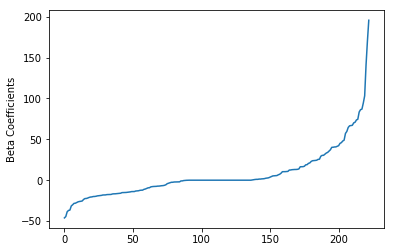

In [73]:

beta = np.sort(lr_model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [74]:
_msummary =lr_model.summary
print("RMSE: %f" % summary.rootMeanSquaredError)
print("r2: %f" % summary.r2)

RMSE: 48.642245
r2: 0.549061


### GRADIENT BOOSTING - TRAINING DATASET

In [0]:
train_df_gbm = train_df.withColumn('label', train_df['price'])

In [0]:
gbt = GBTRegressor(featuresCol="features", maxIter=50)

In [0]:
gbt_fit = gbt.fit(train_df_gbm)

In [0]:
preds = gbt_fit.transform(train_df_gbm)

In [0]:
gbt_fit.transform(train_df_gbm)\
    .select("features", "label", "prediction")\
    .show()

In [81]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(preds)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse)

Root Mean Squared Error (RMSE) on train data = 41.2927


In [82]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(preds)
print("R square on data = %g" % r2)

R square on data = 0.675035


#### GBM model outperformed Linear Regression and Random Forest Model and thus tuning the model further using cross validation

### CROSS VALIDATION -GBM

In [0]:
# Implementing gridsearch in GBM , since we get to know gbm is giving good performance
from pyspark.ml.tuning import CrossValidator


In [0]:
print(gbt.explainParams())

In [0]:
## Crossvalidation on GBM

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [50, 80])
             .build())

In [0]:
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)
cvModel = cv.fit(train_df_gbm)

In [0]:
preds_cv = cvModel.transform(train_df_gbm)

In [0]:
cvModel.transform(train_df_gbm)\
    .select("features", "label", "prediction")\
    .show()

In [90]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(preds_cv)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse)

Root Mean Squared Error (RMSE) on train data = 42.3381


In [91]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(preds_cv)
print("R square on data = %g" % r2)

R square on data = 0.658373


### GRADIENT BOOSTING MODEL - TESTING DATASET (Cross Validation fit and Transform)

In [0]:
test_df_gbm = test_df.withColumn('label', test_df['price'])

In [0]:
preds_test = cvModel.transform(test_df_gbm)

In [0]:
cvModel.transform(test_df_gbm)\
    .select("features", "label", "prediction")\
    .show()

In [99]:
evaluator_test = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator_test.evaluate(preds_test)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 49.8281


In [100]:
evaluator_test = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator_test.evaluate(preds_test)
print("R square on data = %g" % r2)

R square on data = 0.519719


### PLOTS 

In [0]:
import matplotlib.pyplot as plt

In [0]:
trans5.columns

['id',
 'accommodates',
 'bedrooms',
 'beds',
 'price',
 'availability_30',
 'review_scores_rating',
 'reviews_per_month',
 'instant_bookable_idx',
 'neighbourhood_cleansed_idx',
 'room_type_idx',
 'cancellation_policy_idx',
 'neighbourhood_cleansed_vec',
 'room_type_vec',
 'cancellation_policy_vec']

In [0]:
trans5.select('accommodates')

DataFrame[accommodates: int]

In [0]:
trans5_pandas= trans5.toPandas()

In [0]:
from pandas import ExcelWriter

writer = ExcelWriter('PythonExport.xlsx')
trans5_pandas.to_excel(writer,'Sheet5')
writer.save()

In [0]:
trans5_pandas.dtypes

id                             object
accommodates                    int32
bedrooms                        int32
beds                            int32
price                         float64
availability_30                 int32
review_scores_rating            int32
reviews_per_month               int32
instant_bookable_idx          float64
neighbourhood_cleansed_idx    float64
room_type_idx                 float64
cancellation_policy_idx       float64
neighbourhood_cleansed_vec     object
room_type_vec                  object
cancellation_policy_vec        object
dtype: object

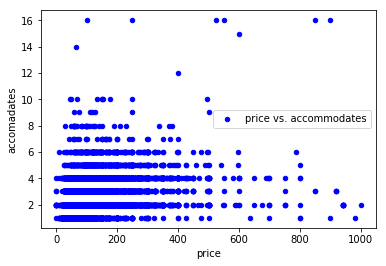

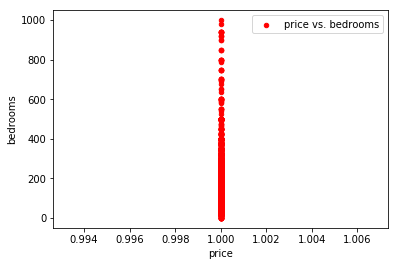

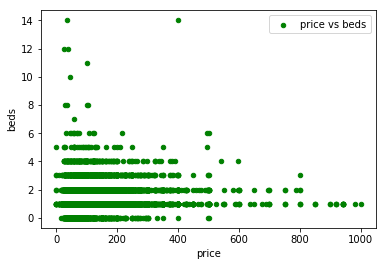

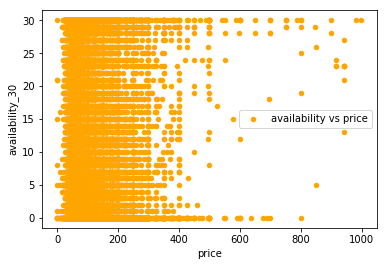

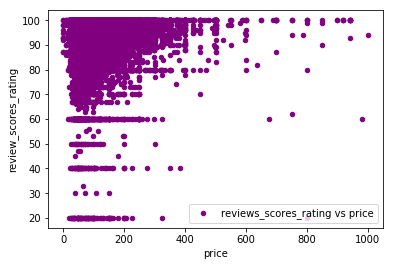

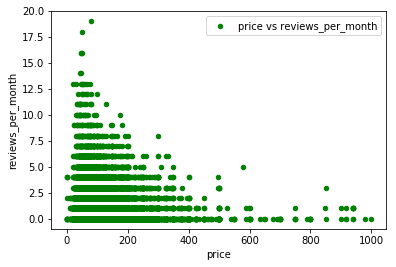

In [0]:
ax = trans5_pandas.plot(kind="scatter", y="accommodates",x="price", color="b", label="price vs. accommodates")

ay=trans5_pandas.plot(kind="scatter",x="bedrooms",y="price", color="r", label="price vs. bedrooms")
az=trans5_pandas.plot( kind="scatter",y="beds",x="price", color="g", label="price vs beds")
aa=trans5_pandas.plot( kind="scatter",y="availability_30",x="price", color="orange", label="availability vs price")
ab=trans5_pandas.plot( kind="scatter",y="review_scores_rating",x="price", color="purple", label="reviews_scores_rating vs price")
ac=trans5_pandas.plot( kind="scatter",y="reviews_per_month",x="price", color="g", label="price vs reviews_per_month")



ax.set_ylabel("accomadates")
ax.set_xlabel("price")
ay.set_ylabel("bedrooms")
ay.set_xlabel("price")
az.set_xlabel("price")
az.set_ylabel("beds")
aa.set_ylabel("availability_30")
aa.set_xlabel("price")
ab.set_ylabel("review_scores_rating")
ab.set_xlabel("price")
ac.set_ylabel("reviews_per_month")
ac.set_xlabel("price")
plt.show()
